In [1]:
# # from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!pwd

/kaggle/working


In [3]:

path = '/kaggle/working/run_1'

In [4]:
# !pip install sparsemax

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt
import copy
# from sparsemax import Sparsemax

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
n_seed = 0
#k = 0

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark= False

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [9]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [10]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [11]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

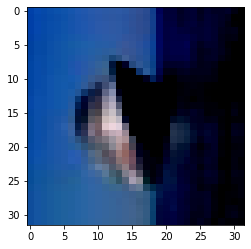

In [12]:
plt.imshow(torch.transpose(mosaic_list_of_images[0][1],dim0= 0,dim1 = 2))

In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [14]:
class my_spherical_softmax(nn.Module):
    """
    implementation is taken from https://github.com/anirbanl/sparsegen 
    Code for the NeurIPS 2018 paper "On Controllable Sparse Alternatives to Softmax"
    """
    def __init__(self):
        super(my_spherical_softmax,self).__init__()
    def forward(self,x):
        bs = x.data.size()[0]
        dim = x.data.size()[1]
        z = torch.pow(x, 2)
        z_sum = torch.sum(z, dim=1).view(bs, 1).repeat(1, dim)
        return z/z_sum

In [15]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0,bias=False)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0,bias=False)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0,bias=False)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1,bias=False)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(64,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(256,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(256,64,bias=False)
    self.fc2 = nn.Linear(64, 32,bias=False)
    self.fc3 = nn.Linear(32, 10,bias=False)
    self.fc4 = nn.Linear(10, 1,bias=False)
    
    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)
    
    #self.sparsemax = Sparsemax(dim=-1) 
    self.spherical_softmax = my_spherical_softmax() 


  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    #ftr = torch.zeros([batch,9,3,32,32])
    y = y.to("cuda")
    x = x.to("cuda")
    #ftr = ftr.to("cuda")
    
    for i in range(9):
        out = self.helper(z[:,i])
        #print(out.shape)
        x[:,i] = out[:,0]
     
    
    x = self.spherical_softmax(x)

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y #alpha,avg_data
    
  def helper(self, x):
    #x1 = x
    #x1 =x
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    
    x = F.relu(self.batch_norm3(x))

    x = self.conv6(x)
    
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [16]:
torch.manual_seed(n_seed)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [17]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
    self.batch_norm1 = nn.BatchNorm2d(128,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(256,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(512,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.global_average_pooling = nn.AvgPool2d(kernel_size=4)
    self.fc1 = nn.Linear(512,128)
    # self.fc2 = nn.Linear(128, 64)
    # self.fc3 = nn.Linear(64, 10)
    self.fc2 = nn.Linear(128, 3)


    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.zeros_(self.conv2.bias)
    torch.nn.init.zeros_(self.conv3.bias)
    torch.nn.init.zeros_(self.conv4.bias)
    torch.nn.init.zeros_(self.conv5.bias)
    torch.nn.init.zeros_(self.conv6.bias)


    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.zeros_(self.fc2.bias)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    x = F.relu(self.batch_norm3(x))

    x = (F.relu(self.conv6(x)))
    x = self.pool(x)
    #print(x.shape)
    x = self.global_average_pooling(x)
    x = x.squeeze()
    #x = x.view(x.size(0), -1)
    #print(x.shape)
    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc2(x))
    #x = self.dropout2(x)
    #x = F.relu(self.fc3(x))
    x = self.fc2(x)
    return x

In [18]:
torch.manual_seed(n_seed)
classify = Classification().double()
classify = classify.to("cuda")

In [19]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [20]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
import torch.optim as optim
# criterion_classify = nn.CrossEntropyLoss()
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.0005)#, momentum=0.9)
optimizer_classify = optim.Adam(classify.parameters(), lr=0.0005)#, momentum=0.9)

In [23]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
col14 = [] # train average sparsity
col15 = [] # test average sparsity



In [24]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0 
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()


    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)
col14.append(sparse_val)

Accuracy of the network on the 30000 train images: 33.703333 %
total correct 10111
total train set images 30000
focus_true_pred_true 2326 =============> FTPT : 7.753333 %
focus_false_pred_true 7785 =============> FFPT : 25.950000 %
focus_true_pred_false 3144 =============> FTPF : 10.480000 %
focus_false_pred_false 16745 =============> FFPF : 55.816667 %
Sparsity_Value 265410 =============> AVG Sparsity : 8.847000 
argmax_more_than_half ==================>  446
argmax_less_than_half ==================>  29554
30000


In [25]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total test set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)
col15.append(sparse_val)

Accuracy of the network on the 10000 test images: 33.410000 %
total correct 3341
total test set images 10000
focus_true_pred_true 774 =============> FTPT : 7.740000 %
focus_false_pred_true 2567 =============> FFPT : 25.670000 %
focus_true_pred_false 1055 =============> FTPF : 10.550000 %
focus_false_pred_false 5604 =============> FFPF : 56.040000 %
Sparsity_Value 88481 =============> AVG Sparsity : 8.848100 
argmax_more_than_half ==================>  169
argmax_less_than_half ==================>  9831


In [26]:
nos_epochs = 50
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
focus_net.train()
classify.train()
tr_loss = []


for epoch in range(nos_epochs):  # loop over the dataset multiple times
  focus_net.train()
  classify.train()
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  sparse_val = 0 
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    # zero the parameter gradients
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    
    # outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 60
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    
    if epoch % 1 == 0:
      sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1


  tr_loss.append(np.mean(epoch_loss))
  if epoch % 1 == 0:
    col1.append(epoch+1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    col14.append(sparse_val)
  
    #************************************************************************
    #testing data set 
    focus_net.eval()
    classify.eval() 
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      sparse_val = 0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images  = focus_net(inputs)
        outputs = classify(avg_images)
        #outputs, alphas, avg_images = classify(inputs)
        _, predicted = torch.max(outputs.data, 1)
        sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    col15.append(sparse_val)
  if(np.mean(epoch_loss) <= 0.05):
    break;
print('Finished Training') 

[1,    60] loss: 1.189
[1,   120] loss: 0.989
[2,    60] loss: 0.883
[2,   120] loss: 0.792
[3,    60] loss: 0.705
[3,   120] loss: 0.641
[4,    60] loss: 0.552
[4,   120] loss: 0.534
[5,    60] loss: 0.470
[5,   120] loss: 0.447
[6,    60] loss: 0.390
[6,   120] loss: 0.374
[7,    60] loss: 0.337
[7,   120] loss: 0.333
[8,    60] loss: 0.292
[8,   120] loss: 0.288
[9,    60] loss: 0.236
[9,   120] loss: 0.259
[10,    60] loss: 0.224
[10,   120] loss: 0.222
[11,    60] loss: 0.197
[11,   120] loss: 0.206
[12,    60] loss: 0.179
[12,   120] loss: 0.175
[13,    60] loss: 0.159
[13,   120] loss: 0.156
[14,    60] loss: 0.129
[14,   120] loss: 0.144
[15,    60] loss: 0.143
[15,   120] loss: 0.145
[16,    60] loss: 0.126
[16,   120] loss: 0.128
[17,    60] loss: 0.114
[17,   120] loss: 0.108
[18,    60] loss: 0.096
[18,   120] loss: 0.105
[19,    60] loss: 0.087
[19,   120] loss: 0.098
[20,    60] loss: 0.085
[20,   120] loss: 0.079
[21,    60] loss: 0.090
[21,   120] loss: 0.086
[22,    60

In [27]:
torch.save(focus_net.state_dict(),path+"weights_focus_0.pt")  
torch.save(classify.state_dict(),path+"weights_classify_0.pt")

In [28]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ,"sparse_val"]

In [29]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [30]:
len(col1),col9

(33,
 [9831,
  7987,
  5912,
  4732,
  4654,
  4179,
  3705,
  3086,
  3279,
  3256,
  3116,
  2756,
  2755,
  2487,
  2254,
  1976,
  2746,
  1960,
  2387,
  2581,
  2054,
  2079,
  2647,
  2182,
  2561,
  2025,
  2140,
  2120,
  2277,
  2195,
  1864,
  2013,
  2422])

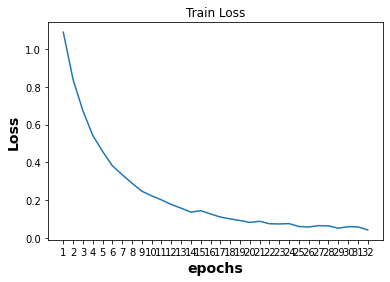

In [31]:
plt.plot(np.arange(1,epoch+2),tr_loss)
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("Loss", fontsize=14, fontweight = 'bold')
plt.xticks(np.arange(1,epoch+2))
plt.title("Train Loss")
#plt.grid()
plt.show()

In [32]:
np.save("train_loss.npy",{"training_loss":tr_loss})

In [33]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7
df_train[columns[7]] = col14

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13
df_test[columns[7]] = col15

In [34]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false,sparse_val
0,0,446,29554,2326,7785,3144,16745,265410
1,1,5323,24677,5711,8066,3525,12698,256683
2,2,9705,20295,11449,7182,3258,8111,256062
3,3,14136,15864,14671,6465,2931,5933,236237
4,4,16367,13633,16876,6185,2490,4449,216227
5,5,17584,12416,18389,5896,2112,3603,203763
6,6,18911,11089,19495,5825,1809,2871,188320
7,7,20129,9871,20392,5670,1576,2362,173531
8,8,20801,9199,21128,5575,1285,2012,166728
9,9,21191,8809,21793,5476,1120,1611,161665


In [35]:
df_train.to_csv(path+"_train.csv",index=False)

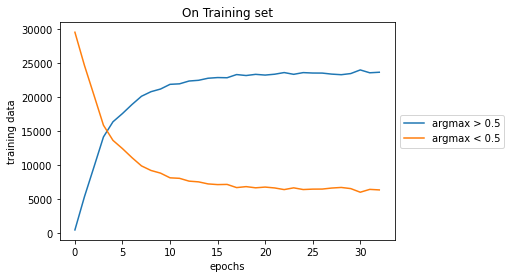

In [36]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()



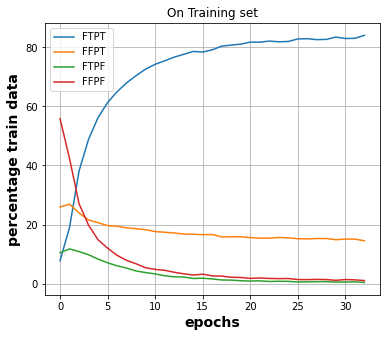

In [37]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/300, label ="FTPT ")
plt.plot(col1,np.array(col5)/300, label ="FFPT ")
plt.plot(col1,np.array(col6)/300, label ="FTPF ")
plt.plot(col1,np.array(col7)/300, label ="FFPF ")
plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("training data")
plt.legend()

plt.savefig(path + "_train.png",bbox_inches="tight")
plt.savefig(path + "_train.pdf",bbox_inches="tight")
plt.grid()
plt.show()

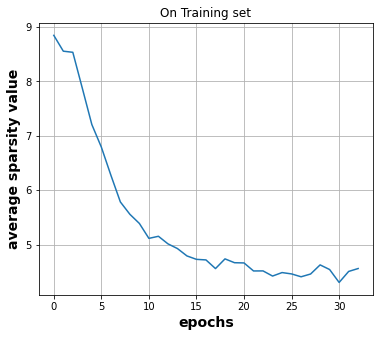

In [38]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col14)/30000, label ="sparsity_val")

plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("average sparsity value", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("sparsity_value")

plt.savefig(path + "sparsity_train.png",bbox_inches="tight")
plt.savefig(path + "sparsity_train.pdf",bbox_inches="tight")
plt.grid()
plt.show()

In [39]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false,sparse_val
0,0,169,9831,774,2567,1055,5604,88481
1,1,2013,7987,3414,2442,1161,2983,89132
2,2,4088,5912,4400,2274,1095,2231,83140
3,3,5268,4732,5581,1942,900,1577,75076
4,4,5346,4654,5837,1857,768,1538,74272
5,5,5821,4179,6259,1881,703,1157,66288
6,6,6295,3705,6535,1812,715,938,60786
7,7,6914,3086,7001,1613,561,825,55092
8,8,6721,3279,7059,1696,521,724,56851
9,9,6744,3256,7320,1573,433,674,57111


In [40]:
df_test.to_csv(path+"_test.csv")

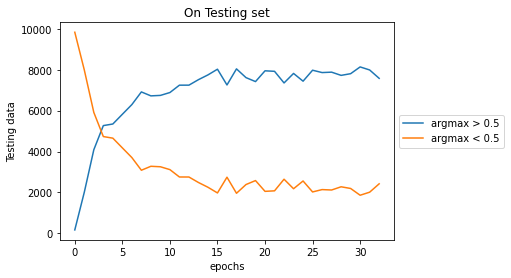

In [41]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()



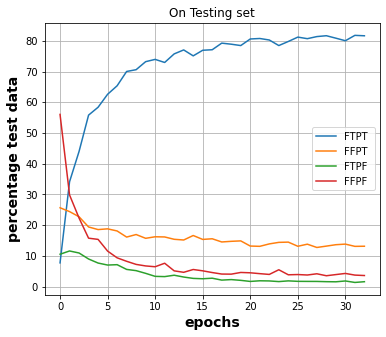

In [42]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/100, label ="FTPT ")
plt.plot(col1,np.array(col11)/100, label ="FFPT ")
plt.plot(col1,np.array(col12)/100, label ="FTPF ")
plt.plot(col1,np.array(col13)/100, label ="FFPF ")
plt.title("On Testing set")

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("training data")
plt.legend()

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
# plt.ylabel("Testing data")
plt.savefig(path + "_test.png",bbox_inches="tight")
plt.savefig(path + "_test.pdf",bbox_inches="tight")
plt.grid()
plt.show()

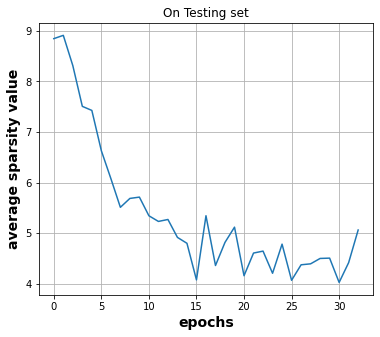

In [43]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col15)/10000, label ="sparsity_val")

plt.title("On Testing set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("average sparsity value", fontsize=14, fontweight = 'bold')
plt.grid()

plt.savefig(path + "sparsity_test.png",bbox_inches="tight")
plt.savefig(path + "sparsity_test.pdf",bbox_inches="tight")
plt.show()

In [44]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

Accuracy of the network on the 30000 train images: 99.263333 %
total correct 29779
total train set images 30000
focus_true_pred_true 25524 =============> FTPT : 85.080000 %
focus_false_pred_true 4255 =============> FFPT : 14.183333 %
focus_true_pred_false 62 =============> FTPF : 0.206667 %
focus_false_pred_false 159 =============> FFPF : 0.530000 %
Sparsity_Value 143571 =============> AVG Sparsity : 4.785700 
argmax_more_than_half ==================>  23469
argmax_less_than_half ==================>  6531
30000


In [45]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0 
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images  = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total test set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 94.770000 %
total correct 9477
total test set images 10000
focus_true_pred_true 8162 =============> FTPT : 81.620000 %
focus_false_pred_true 1315 =============> FFPT : 13.150000 %
focus_true_pred_false 161 =============> FTPF : 1.610000 %
focus_false_pred_false 362 =============> FFPF : 3.620000 %
Sparsity_Value 50599 =============> AVG Sparsity : 5.059900 
argmax_more_than_half ==================>  7578
argmax_less_than_half ==================>  2422


In [46]:
correct = 0
total = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 99.230000 %
total correct 29769
total train set images 30000


In [47]:
correct = 0
total = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 94.770000 %
total correct 9477
total train set images 10000
